# USING SQL FROM PYTHON

# 1) INTRODUCTION

# a) Objective

In this notebook I will use python to perform a SQL query on a database, and perform statistical analysis and visualizations using python/matplotlib. The data is taken from the Lahman Baseball Database.

With that goal in mind, I will perform the analysis on the different data from:

- Players
- Teams

I will specifically focus on the information about pitching.

# b) The Lahman Baseball Database

The data is obtained from the Lahman Baseball Database. This database contains complete batting and pitching statistics from 1871 to 2017, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. We will select the database which goes to the year 2016, as the one for 2017 is not complete yet. 

All the data from the database are stored in the following webpage: http://www.seanlahman.com/baseball-archive/statistics/.


# c) Pitching statistics

 According to the MBL (https://en.wikipedia.org/wiki/Baseball_statistics) statistical standards, the most important statistical variables are:

- VORP (Value over replacement player)

$VORP=IP\frac{\left(\frac{R}{G}+1\right)-RA}{9}$  

- K/9IP (strikeouts per nine innings)

$K/9IP=9\frac{K}{IP}$

- K/BB (strikeouts per walk)

$K/BB=\frac{K}{BB}$

- HR/9IP (Home runs per nine innings)

$HR/9IP=9\frac{HR}{IP}$

- WHIP (walks plus hits per inning pitched)

$WHIP=\frac{BB+H}{IP}$

# d) Tools
- Python module 'sqlite3' to query the database
- Python module pandas to analyse the data
- Python module matplotlib and seaborn to plot the results.

# 2) STATISTICAL ANALYSIS OF THE PLAYERS

The first object to study is the performance of the players. The statistics will allow us to understand which players are better. The first analysis will be performed on the statistics from the last season (2016). Secondly, I will study the time variation of the players statistics in the last 5 years and understand the time evolution of the players.

# a) Last season statistics
I will study the most relevant statistics according to pitching for the last season.


In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy
%matplotlib inline
import matplotlib.ticker as ticker


In [2]:
sqlite_file = 'lahman2016.sqlite'    # name of the sqlite database file

# Connecting to the database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# CREATING THE DATAFRAMES FOR EACH STATISTICAL VARIABLE
# QUERYING FOR VORP
VORP_query='SELECT distinct Pitching.yearID, Master.playerID, MASTER.nameFIRST, MASTER.nameLAST,  CAST(Pitching.IPOuts AS FLOAT) *    (((CAST(Pitching.R AS FLOAT)/CAST(Pitching.G AS FLOAT))+1-CAST(Pitching.ERA AS FLOAT))    / 9 ) AS VORP  FROM Pitching INNER JOIN Master on MASTER.playerID=Pitching.playerID   WHERE Pitching.yearID = 2016  AND Pitching.G >=10  group BY Pitching.PLAYERID  ORDER BY VORP DESC'
df_VORP=pd.read_sql(VORP_query,conn)

# QUERYING FOR K9IP
K9IP_query='SELECT distinct Pitching.yearID, Master.playerID, MASTER.nameFIRST, MASTER.nameLAST, 9* CAST(Pitching.SO AS FLOAT)   / CAST(Pitching.IPOuts AS FLOAT)  AS K9IP  FROM Pitching INNER JOIN Master on MASTER.playerID=Pitching.playerID   WHERE Pitching.yearID = 2016 AND Pitching.G >=10  group BY Pitching.PLAYERID   ORDER BY K9IP DESC'
df_K9IP=pd.read_sql(K9IP_query,conn)

# QUERYING FOR KBB
KBB_query='SELECT distinct Pitching.yearID, Master.playerID, MASTER.nameFIRST, MASTER.nameLAST,  CAST(Pitching.SO AS FLOAT)   / CAST(Pitching.BB AS FLOAT)  AS KBB FROM Pitching INNER JOIN Master on MASTER.playerID=Pitching.playerID  WHERE Pitching.yearID = 2016 AND Pitching.G >=10  group BY Pitching.PLAYERID ORDER BY KBB DESC'
df_KBB=pd.read_sql(KBB_query,conn)


# QUERYING FOR HR9IP
HR9IP_query='SELECT distinct Pitching.yearID, Master.playerID, MASTER.nameFIRST, MASTER.nameLAST,  9*CAST(Pitching.HR AS FLOAT)   / CAST(Pitching.IPOuts AS FLOAT)  AS HR9IP  FROM Pitching  INNER JOIN Master on MASTER.playerID=Pitching.playerID   WHERE Pitching.yearID = 2016  AND Pitching.G >=10  group BY Pitching.PLAYERID  ORDER BY HR9IP DESC'
df_HR9IP=pd.read_sql(HR9IP_query,conn)


# QUERYING FOR WHIP
WHIP_query='SELECT distinct Pitching.yearID, Master.playerID, MASTER.nameFIRST, MASTER.nameLAST,  (CAST(Pitching.BB AS FLOAT) + CAST(Pitching.H AS FLOAT) ) / CAST(Pitching.IPOuts AS FLOAT)  AS WHIP  FROM Pitching  INNER JOIN Master on MASTER.playerID=Pitching.playerID     WHERE Pitching.yearID = 2016 AND Pitching.G >=10  group BY Pitching.PLAYERID  ORDER BY WHIP DESC'
df_WHIP=pd.read_sql(WHIP_query,conn)



# Committing changes and closing the connection to the database file
conn.close()

In [3]:
# We create one column with the index
df_VORP.reset_index(level=0, inplace=True)
df_K9IP.reset_index(level=0, inplace=True)
df_KBB.reset_index(level=0, inplace=True)
df_HR9IP.reset_index(level=0, inplace=True)
df_WHIP.reset_index(level=0, inplace=True)

#We rename the column index
df_VORP=df_VORP.rename(columns={'index':'index_VORP'})
df_K9IP=df_K9IP.rename(columns={'index':'index_K9IP'})
df_KBB=df_KBB.rename(columns={'index':'index_KBB'})
df_HR9IP=df_HR9IP.rename(columns={'index':'index_HR9IP'})
df_WHIP=df_WHIP.rename(columns={'index':'index_WHIP'})

#We merge the different tables into one
result=pd.merge(df_VORP, df_K9IP, on=['yearID','nameFirst','nameLast','playerID'],copy=False)
result2=pd.merge(result, df_KBB, on=['yearID','nameFirst','nameLast','playerID'],copy=False)
result3=pd.merge(result2, df_HR9IP, on=['yearID','nameFirst','nameLast','playerID'],copy=False)
result4=pd.merge(result3, df_WHIP, on=['yearID','nameFirst','nameLast','playerID'],copy=False)

#We reorder the culomns in the dataframe
df_final = result4[['yearID','nameFirst','nameLast','playerID','VORP','index_VORP', 'K9IP', 'index_K9IP', 'KBB', 'index_KBB', 
       'HR9IP','index_HR9IP', 'WHIP', 'index_WHIP']]


#We create a column which would be named "sum_index". This index is the sum of all the normalized indeces from before, which sets the position of the player in all the different statistics
df_final.loc[:,'normalized_index'] = pd.Series(df_final['index_VORP']/max(df_final['index_VORP'])+df_final['index_K9IP']/max(df_final['index_K9IP'])+df_final['index_KBB']/max(df_final['index_KBB'])+df_final['index_HR9IP']/max(df_final['index_HR9IP'])+df_final['index_WHIP']/max(df_final['index_WHIP']), index=df_final.index)
df_final.sort_values(by=['normalized_index']).head()

/Users/santi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/santi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,yearID,nameFirst,nameLast,playerID,VORP,index_VORP,K9IP,index_K9IP,KBB,index_KBB,HR9IP,index_HR9IP,WHIP,index_WHIP,normalized_index
229,2016,Dario,Alvarez,alvarda01,-21.816667,229,3.342857,96,6.500000,11,0.771429,25,0.542857,74,0.807050
176,2016,Josh,Smoker,smokejo01,-16.355556,176,4.891304,3,6.250000,13,0.782609,23,0.434783,291,0.938776
315,2016,Brooks,Pounders,poundbr01,-30.568889,315,3.078947,164,4.333333,66,1.421053,1,0.578947,41,1.089054
251,2016,Chad,Green,greench03,-23.797407,251,3.416058,83,3.466667,125,0.788321,22,0.467153,208,1.278293
205,2016,Danny,Farquhar,farquda01,-19.551111,205,3.905660,30,3.066667,179,0.679245,40,0.452830,244,1.294991


In this table we find the players, ordered from "best" to "worst" according to the new variable which we have defined to take into account all the variables defined before. There are some caveats:

- There may be players with the same value of a characteristic (e.g., VORP) but the index would be different

We define the best players as the first 10 with the lowest normalized variable:

In [4]:
best_players=df_final['playerID'][0:9]
best_players

0    bumgama01
1    wrighst01
2    kershcl01
3    hendrky01
4    porceri01
5    cuetojo01
6     salech01
7    klubeco01
8    verlaju01
Name: playerID, dtype: object

# b) Last five-years statistics
We will study the most relevant statistics according to pitching for the last five years. In our case, the queries would be the same but restricting our query to the years 2012-2016



In [5]:
# Connecting to the database file
conn = sqlite3.connect(sqlite_file)

all_query='SELECT distinct Pitching.yearID, Master.playerID, MASTER.nameFIRST, MASTER.nameLAST,  CAST(Pitching.IPOuts AS FLOAT) *    (((CAST(Pitching.R AS FLOAT)/CAST(Pitching.G AS FLOAT))+1-CAST(Pitching.ERA AS FLOAT))    / 9 ) AS VORP, 9* CAST(Pitching.SO AS FLOAT)   / CAST(Pitching.IPOuts AS FLOAT)  AS K9IP, CAST(Pitching.SO AS FLOAT)   / CAST(Pitching.BB AS FLOAT)  AS KBB, 9*CAST(Pitching.HR AS FLOAT)   / CAST(Pitching.IPOuts AS FLOAT)  AS HR9IP, (CAST(Pitching.BB AS FLOAT) + CAST(Pitching.H AS FLOAT) ) / CAST(Pitching.IPOuts AS FLOAT)  AS WHIP FROM Pitching  INNER JOIN Master on MASTER.playerID=Pitching.playerID     WHERE Pitching.yearID >= 2012 AND Pitching.yearID <= 2016 AND Pitching.G >=10   ORDER BY Pitching.playerID ASC'
df_five_yr=pd.read_sql(all_query,conn)


# Committing changes and closing the connection to the database file
conn.close()

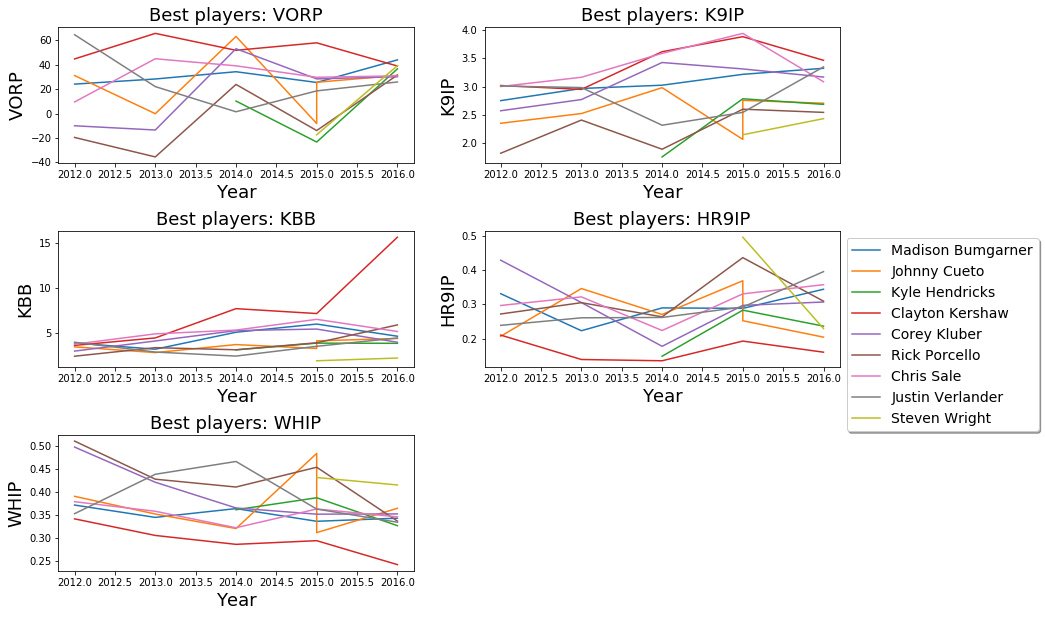

In [6]:
result5=df_five_yr.sort_values(['yearID']).groupby(['playerID'])

# I plot the resulting baseball variables of the best players between 2012 and 2016
fig = plt.figure(figsize=(14,10))
i_plot = 0
nh, nv = 2,3
gs = gridspec.GridSpec(nv, nh)  
ax_each = []
characteristics=('VORP', 'K9IP', 'KBB','HR9IP', 'WHIP')

for characteristic in characteristics:
    ax = fig.add_subplot(gs[int(i_plot / nh), i_plot % nh])
    ax.set_title('Best players: %s'%characteristic, fontsize=18)
    ax.set_ylabel(characteristic, fontsize=18)
    ax.set_xlabel(r'Year', fontsize=18) 
    for groupings in result5:
        times=[]            
        VORP_vals=[]  
        for best in best_players:
            if groupings[0]==best:
                for i in range(len(groupings[1][['yearID']].unstack())):
                    times.append(groupings[1][['yearID']].unstack()[i])
                    VORP_vals.append(groupings[1][[characteristic]].unstack()[i])
                ax.plot(times,VORP_vals,label=str(groupings[1][['nameFirst']].unstack()[i])+' '+str(groupings[1][['nameLast']].unstack()[i]))
    if characteristic=='HR9IP':
        ax.legend(loc=2, scatterpoints=1, frameon=True, fontsize=14,bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=True)
    i_plot += 1
    ax_each.append(ax)

gs.update(wspace=0.2, hspace=0.5)


# 3)  STATISTICAL ANALYSIS OF THE TEAMS

This section will study the performance of the teams with regards to the parameters studied before.

# a) Cumulative statistics

In [7]:
# In this subsection, I sum the baseball variables from 2012 to 2016.
# Connecting to the database file
conn = sqlite3.connect(sqlite_file)

all_teams_sum_query='SELECT distinct Teams.name,  SUM(CAST(Teams.IPOuts AS FLOAT) *      (((CAST(Teams.R AS FLOAT)/CAST(Teams.G AS FLOAT))  +1-CAST(Teams.ERA AS FLOAT))    / 9 )) AS VORP,   SUM(9* CAST(Teams.SO AS FLOAT)   / CAST(Teams.IPOuts AS FLOAT))  AS K9IP,   SUM(CAST(Teams.SO AS FLOAT)   / CAST(Teams.BB AS FLOAT) ) AS KBB,   SUM(9*CAST(Teams.HR AS FLOAT)   / CAST(Teams.IPOuts AS FLOAT))  AS HR9IP,   SUM((CAST(Teams.BB AS FLOAT) + CAST(Teams.H AS FLOAT) ) / CAST(Teams.IPOuts AS FLOAT))  AS WHIP   FROM Teams    WHERE Teams.yearID >= 2012 AND Teams.yearID <= 2016  AND Teams.G >=10     GROUP BY Teams.name ORDER BY Teams.name ASC'
df_all_teams_sum=pd.read_sql(all_teams_sum_query,conn)


# Committing changes and closing the connection to the database file
conn.close()

In [8]:
df_all_teams_sum.head()

,name,VORP,K9IP,KBB,HR9IP,WHIP
0,Arizona Diamondbacks,2628.899630,12.993929,13.235940,1.558976,2.204622
1,Atlanta Braves,2788.049586,13.260612,12.547736,1.400574,2.152726
2,Baltimore Orioles,3654.057558,13.177899,14.661669,2.287579,2.119166
3,Boston Red Sox,3833.194513,12.719098,12.027612,1.728981,2.311216
4,Chicago Cubs,3206.829355,14.065535,13.624722,1.729002,2.120173


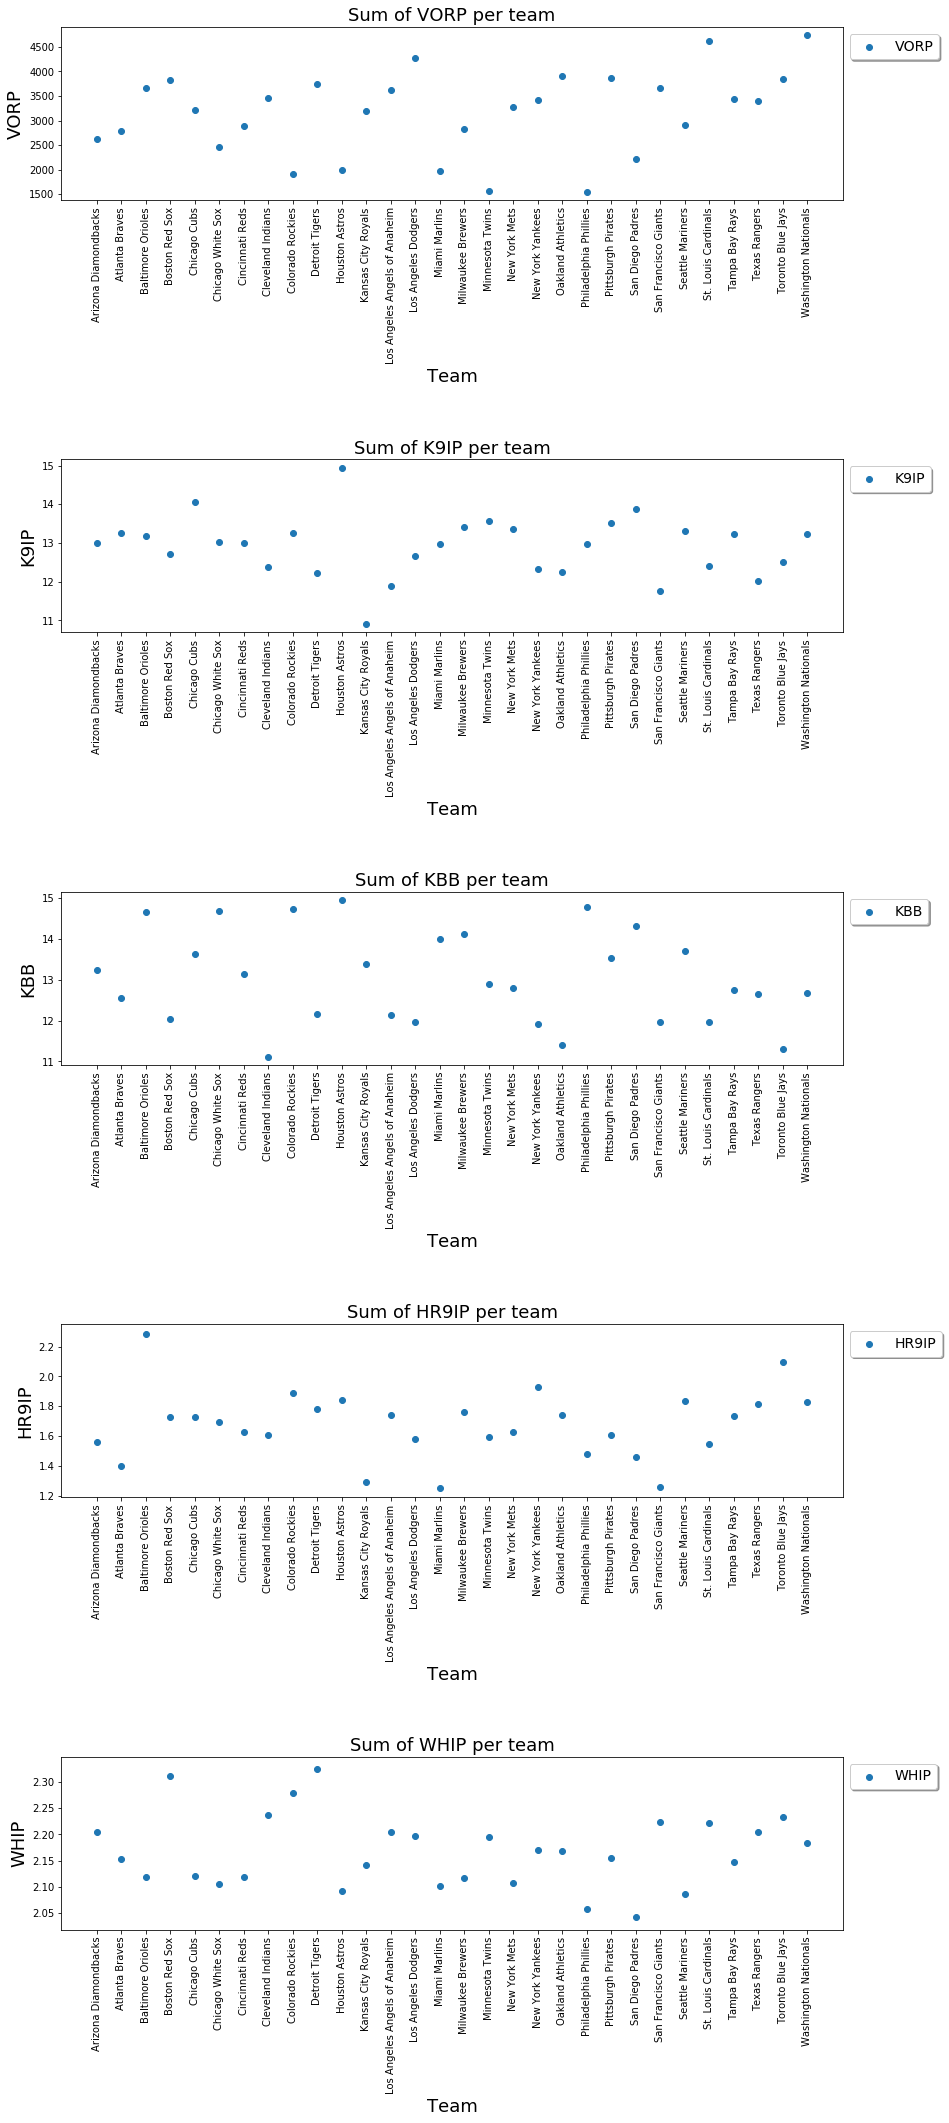

In [9]:
# Plot the resuls
fig = plt.figure(figsize=(14,35))
i_plot = 0
nh, nv = 1,5
gs = gridspec.GridSpec(nv, nh)  
ax_each = []
characteristics=('VORP', 'K9IP', 'KBB','HR9IP', 'WHIP')

for characteristic in characteristics:
    ax = fig.add_subplot(gs[int(i_plot / nh), i_plot % nh])
    ax.set_title('Sum of %s per team'%characteristic, fontsize=18)
    ax.set_ylabel(characteristic, fontsize=18)
    ax.set_xlabel("Team", fontsize=18)
    ax.set_xticklabels(labels=df_all_teams_sum['name'],rotation=90)    
    ax.scatter(df_all_teams_sum['name'],df_all_teams_sum[characteristic],label=characteristic)
    ax.legend(loc=2, scatterpoints=1, frameon=True, fontsize=14,bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=True)
    i_plot += 1
    ax_each.append(ax)
gs.update(wspace=0.5, hspace=1.5)

# 4) STATISTICAL ANALYSIS OF THE BEST PLAYERS FROM NY YANKEES

In this section, the best players from the NY Yankees are analysed. Their baseball variables are studied and compared to the other best players from the other teams.

In [10]:
# We perform the query
# Connecting to the database file
conn = sqlite3.connect(sqlite_file)

all_query='SELECT distinct Teams.teamID, t.yearID AS yearID, t.playerID as playerID, t.nameFIRST as nameFIRST, t.nameLAST as nameLAST,  CAST(t.IPOuts AS FLOAT) *    (((CAST(Teams.R AS FLOAT)/CAST(Teams.G AS FLOAT))+1-CAST(t.ERA AS FLOAT))    / 9 ) AS VORP, 9* CAST(t.SO AS FLOAT)   / CAST(t.IPOuts AS FLOAT)  AS K9IP, CAST(t.SO AS FLOAT)   / CAST(t.BB AS FLOAT)  AS KBB, 9*CAST(t.HR AS FLOAT)   / CAST(t.IPOuts AS FLOAT)  AS HR9IP, (CAST(t.BB AS FLOAT) + CAST(t.H AS FLOAT) ) / CAST(t.IPOuts AS FLOAT)  AS WHIP  FROM Teams  INNER JOIN (   SELECT Pitching.SO as SO, Pitching.BB as BB,Pitching.HR as HR, Pitching.H as H, Pitching.yearID AS yearID, Pitching.playerID as playerID, Master.nameFIRST as nameFIRST, Master.nameLAST as nameLAST, Pitching.IPOuts as IPOuts, Pitching.ERA as ERA, Pitching.teamID as teamID  FROM Pitching INNER JOIN Master ON MASTER.playerID=Pitching.playerID WHERE yearID BETWEEN 2012 AND 2016 AND Pitching.G >=10) t  ON Teams.teamID = t.teamID AND Teams.yearID = t.yearID    ORDER BY t.playerID ASC'
df_five_yr=pd.read_sql(all_query,conn)


# Committing changes and closing the connection to the database file
conn.close()

In [11]:
# We see the result from the query
df_five_yr.sort_values(by=['VORP'],ascending=False).head()

,teamID,yearID,playerID,nameFIRST,nameLAST,VORP,K9IP,KBB,HR9IP,WHIP
75,CHN,2015,arrieja01,Jake,Arrieta,265.875597,3.091703,4.916667,0.131004,0.288210
973,LAN,2015,greinza01,Zack,Greinke,256.607298,2.694611,5.000000,0.188623,0.281437
1303,LAN,2013,kershcl01,Clayton,Kershaw,249.858930,2.949153,4.461538,0.139831,0.305085
1100,CHN,2016,hendrky01,Kyle,Hendricks,244.318107,2.684211,3.863636,0.236842,0.326316
1973,BOS,2016,porceri01,Rick,Porcello,243.051646,2.542601,5.906250,0.309417,0.336323


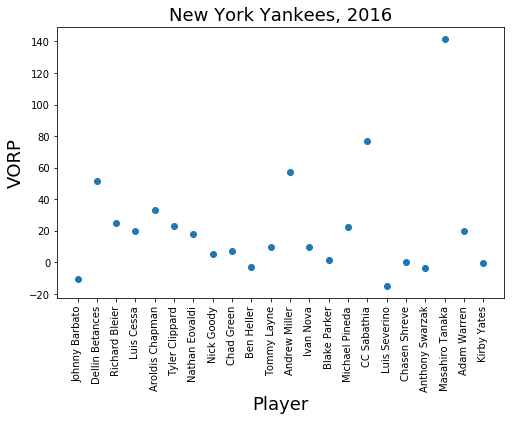

In [12]:
# We focus on the team NYA, year 2016 and plot the best players according to the VORP variable 
df2=df_five_yr[df_five_yr["teamID"]=="NYA"]
df3=df2[df2["yearID"]==2016].sort_values(by=['nameLAST'])
df3.head()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('New York Yankees, 2016', fontsize=18)
ax.set_ylabel("VORP", fontsize=18)
ax.set_xlabel("Player", fontsize=18)
ax.set_xticklabels(labels=df3['nameFIRST']+" "+df3['nameLAST'],rotation=90)

ax.scatter(df3['playerID'],df3['VORP'])

In [13]:
# The baseball variables are normalized in two ways: by teams and by all players
df4=df_five_yr.groupby(['teamID']).agg({"VORP": 'max', "K9IP": 'max',"KBB": 'max',"HR9IP": 'max',"WHIP": 'max'}).rename(columns={"VORP": "VORP_max","K9IP": "K9IP_max","KBB": "KBB_max","HR9IP": "HR9IP_max","WHIP": "WHIP_max"}).reset_index()
df5=df_five_yr.groupby(['teamID']).agg({"VORP": 'min', "K9IP": 'min',"KBB": 'min',"HR9IP": 'min',"WHIP": 'min'}).rename(columns={"VORP": "VORP_min","K9IP": "K9IP_min","KBB": "KBB_min","HR9IP": "HR9IP_min","WHIP": "WHIP_min"}).reset_index()
df6=df_five_yr.merge(df4,how='outer',on='teamID').merge(df5,how='outer',on='teamID')
df6['VORP_norm_team']=(df6['VORP']-df6['VORP_min'])/(df6['VORP_max']-df6['VORP_min'])
df6['VORP_norm_all']=(df6['VORP']-min(df6['VORP']))/(max(df6['VORP'])-min(df6['VORP']))
df6['K9IP_norm_team']=(df6['K9IP']-df6['K9IP_min'])/(df6['K9IP_max']-df6['K9IP_min'])
df6['K9IP_norm_all']=(df6['K9IP']-min(df6['K9IP']))/(max(df6['K9IP'])-min(df6['K9IP']))
df6['KBB_norm_team']=(df6['KBB']-df6['KBB_min'])/(df6['KBB_max']-df6['KBB_min'])
df6['KBB_norm_all']=(df6['KBB']-min(df6['KBB']))/(max(df6['KBB'])-min(df6['KBB']))
df6['HR9IP_norm_team']=(df6['HR9IP']-df6['HR9IP_min'])/(df6['HR9IP_max']-df6['HR9IP_min'])
df6['HR9IP_norm_all']=(df6['HR9IP']-min(df6['HR9IP']))/(max(df6['HR9IP'])-min(df6['HR9IP']))
df6['WHIP_norm_team']=(df6['WHIP']-df6['WHIP_min'])/(df6['WHIP_max']-df6['WHIP_min'])
df6['WHIP_norm_all']=(df6['WHIP']-min(df6['WHIP']))/(max(df6['WHIP'])-min(df6['WHIP']))
df6=df6[df6['HR9IP']!=0]
df6=df6.dropna()
df6.head()

,teamID,yearID,playerID,nameFIRST,nameLAST,VORP,K9IP,KBB,HR9IP,WHIP,...,VORP_norm_team,VORP_norm_all,K9IP_norm_team,K9IP_norm_all,KBB_norm_team,KBB_norm_all,HR9IP_norm_team,HR9IP_norm_all,WHIP_norm_team,WHIP_norm_all
0,NYN,2013,aardsda01,David,Aardsma,6.756392,2.722689,1.894737,0.529412,0.487395,...,0.152145,0.244395,0.424206,0.399708,0.181231,0.070837,0.385621,0.358824,0.409844,0.388817
1,NYN,2012,acostma01,Manny,Acosta,-22.840768,2.915493,1.840000,0.443662,0.514085,...,0.005407,0.158088,0.475398,0.434170,0.172453,0.068428,0.323161,0.300704,0.449497,0.420639
2,NYN,2013,atchisc01,Scott,Atchison,6.814925,1.852941,2.333333,0.264706,0.419118,...,0.152435,0.244565,0.193277,0.244246,0.251572,0.090147,0.192810,0.179412,0.308403,0.307410
3,NYN,2016,bastaan01,Antonio,Bastardo,5.850974,3.160305,2.190476,0.549618,0.473282,...,0.147656,0.241754,0.540399,0.477929,0.228661,0.083857,0.400339,0.372519,0.388877,0.371991
4,NYN,2012,batismi01,Miguel,Batista,2.992044,2.185714,1.096774,0.321429,0.600000,...,0.133482,0.233418,0.281633,0.303727,0.053256,0.035707,0.234127,0.217857,0.577143,0.523077


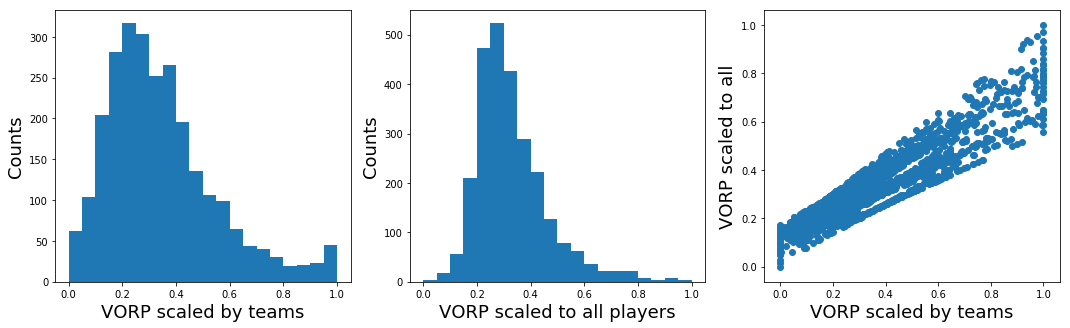

In [14]:
# We plot the VORP statisctics normalized by teams and by all other players, and compare both with matplotlib
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1,3,1)
ax.set_ylabel("Counts", fontsize=18)
ax.set_xlabel("VORP scaled by teams", fontsize=18)
ax.hist(df6['VORP_norm_team'],bins=20)

ax = fig.add_subplot(1,3,2)
ax.set_ylabel("Counts", fontsize=18)
ax.set_xlabel("VORP scaled to all players", fontsize=18)
ax.hist(df6['VORP_norm_all'],bins=20)

ax = fig.add_subplot(1,3,3)
ax.set_ylabel("VORP scaled to all", fontsize=18)
ax.set_xlabel("VORP scaled by teams", fontsize=18)
ax.scatter(df6['VORP_norm_team'],df6['VORP_norm_all'])

In [15]:
# We check if both variables come from the same distribution using the KS 2 sample test
scipy.stats.ks_2samp(df6['VORP_norm_team'],df6['VORP_norm_all'])

Ks_2sampResult(statistic=0.14039785768936497, pvalue=5.901829724308198e-23)

We can reject that both samples come from the same distribution

/Users/santi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


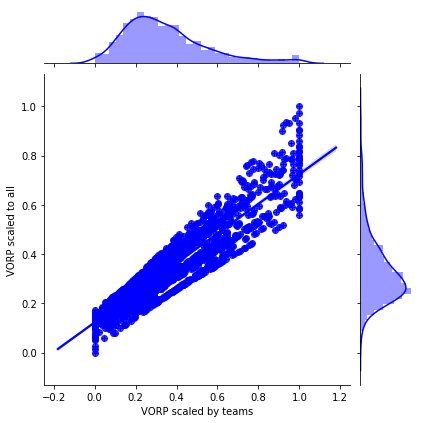

In [16]:
# We plot again both distributions, now with seaborn
g = sns.jointplot(x="VORP_norm_team", y="VORP_norm_all", data=df6, kind="reg", color="b")
g.plot_joint(plt.scatter, c="b", s=30, linewidth=1, marker="+")
g.set_axis_labels("VORP scaled by teams", "VORP scaled to all");

/Users/santi/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/Users/santi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


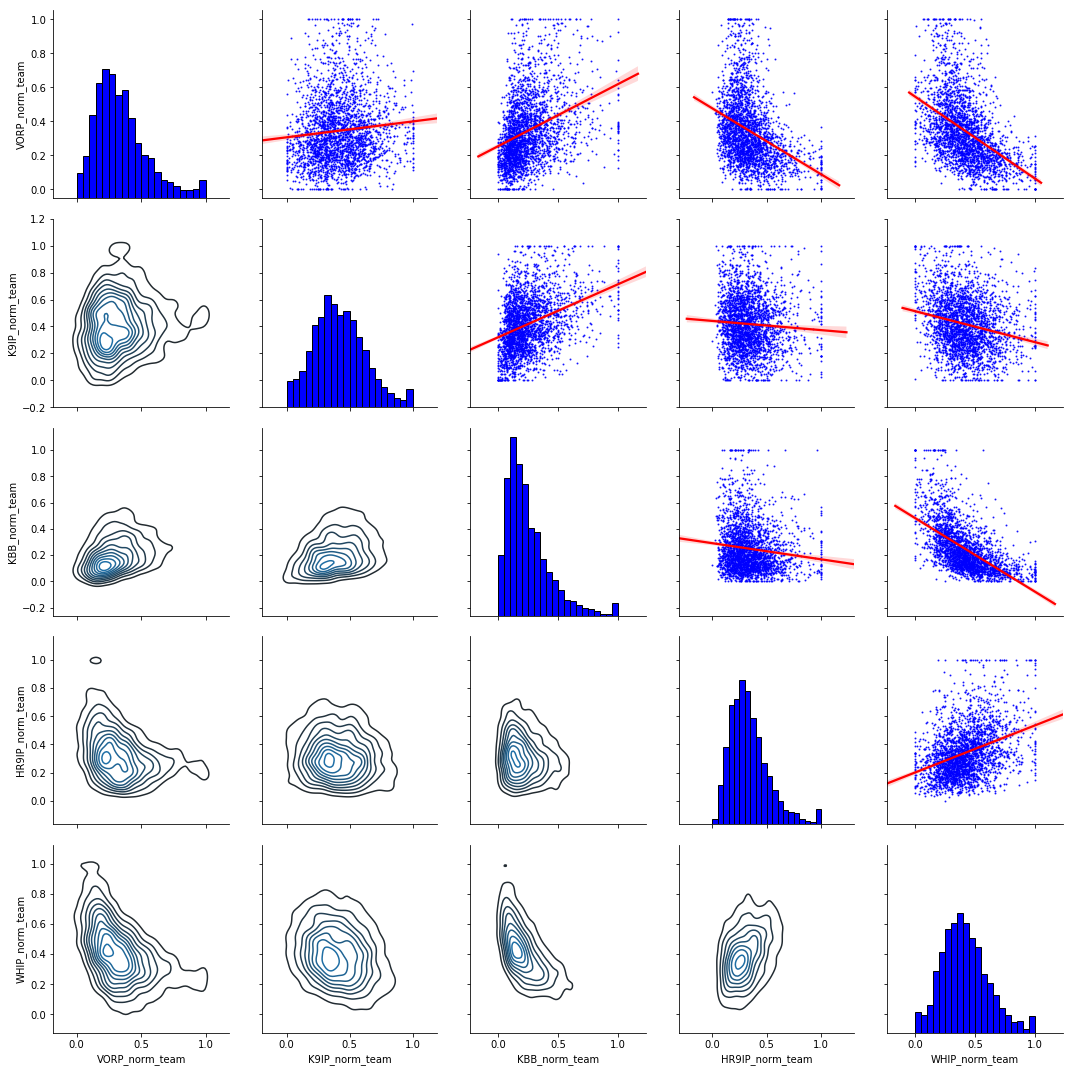

In [17]:
# We compare all the variables with seaborn
# Create an instance of the PairGrid class.
grid = sns.PairGrid(data= df6.dropna(),
                    vars = ['VORP_norm_team', 'K9IP_norm_team', 
                    'KBB_norm_team','HR9IP_norm_team','WHIP_norm_team'], size = 3,dropna=True)
# Map a scatter plot to the upper triangle
grid = grid.map_lower(sns.kdeplot)
# Map a histogram to the diagonal
grid = grid.map_diag(plt.hist, bins = 20, color = 'blue', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_upper(sns.regplot, scatter_kws={"color": "blue","s":1}, line_kws={"color": "red"})


In [18]:
# We select the best players, and create two dataframes with different thresholds in 
df7=df6[df6['VORP']>200]
df7.sort_values(by=['VORP','yearID'], ascending=False)
df7['nameTOTAL'] = df7['nameFIRST'].astype(str) + ' '+df7['nameLAST']
df8=df6[df6['VORP']>190]
df8.sort_values(by=['VORP','yearID'], ascending=False)
df8['nameTOTAL'] = df8['nameFIRST'].astype(str) + ' '+df8['nameLAST']
df6['nameTOTAL'] = df6['nameFIRST'].astype(str) + ' '+df6['nameLAST']

/Users/santi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/santi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


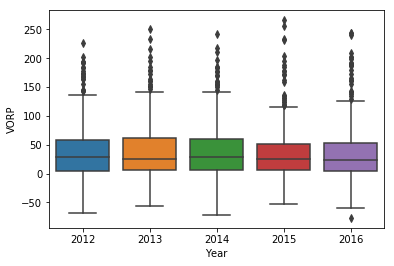

In [19]:
# We plot the distribution of VROP with year
fig, ax = plt.subplots()
ax = sns.boxplot(x="yearID", y="VORP",data=df6)
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('VORP', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# plt.savefig('boxplot_VORP_year.pdf', bbox_inches='tight',dpi=72)  
None

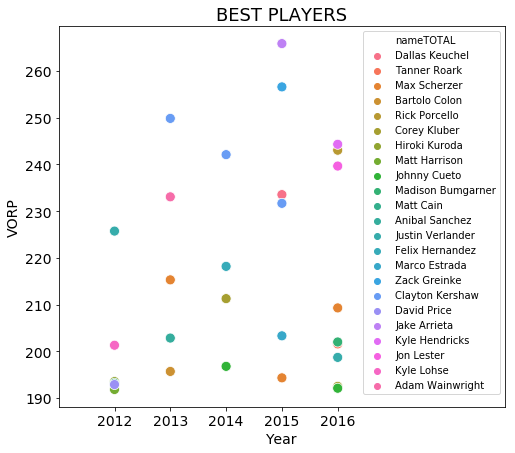

In [20]:
# We plot the best players
fig = plt.figure(figsize=(8., 7))
ax = sns.scatterplot(x="yearID", y="VORP", hue='nameTOTAL',data=df8,s=100)
ax.set_xticks(ticks=[2012,2013,2014,2015,2016], minor=False)
ax.set_xlim(2011,2019)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('VORP', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_title('BEST PLAYERS', fontsize=18)
# plt.savefig('VORP_year_zoom.pdf', bbox_inches='tight',dpi=72)
None

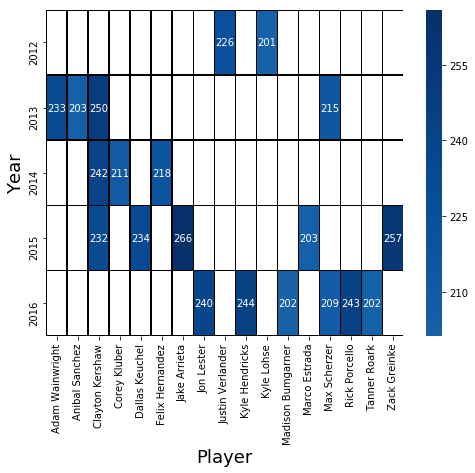

In [21]:
# We look at how many of the best players show the best scores in the five years of study with the first threshold in VORP
fig = plt.figure(figsize=(8., 6.))
table_melt2 = df7.pivot('yearID','nameTOTAL','VORP')
g = sns.heatmap(table_melt2, annot=True, linecolor='black', linewidths=.5, fmt='0.0f', center=100,cmap='Blues')
g.set_ylabel('Year', fontsize=18)
g.set_xlabel('Player', fontsize=18)
ax.tick_params(axis='both', labelsize=18)
# plt.savefig('VORP_year_heatmap.pdf', bbox_inches='tight',dpi=72)
None

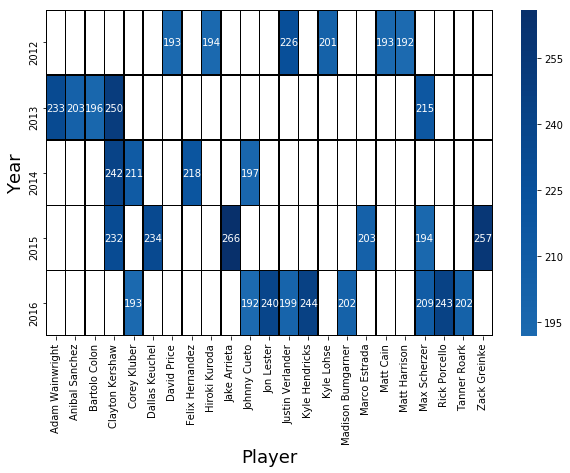

In [22]:
# We look at how many of the best players show the best scores in the five years of study with the second threshold in VORP
fig = plt.figure(figsize=(10., 6.))
table_melt2 = df8.pivot('yearID','nameTOTAL','VORP')
g = sns.heatmap(table_melt2, annot=True, fmt='0.0f', linecolor='black', linewidths=.5, center=100,cmap='Blues')
g.set_ylabel('Year', fontsize=18)
g.set_xlabel('Player', fontsize=18)
ax.tick_params(axis='both', labelsize=18)
None

In [23]:
# We see that there are two players that have best scores in VORP in more than one year: Clayton K. and Max S.
df_clay=df6[df6['nameTOTAL']=='Clayton Kershaw']
df_max=df6[df6['nameTOTAL']=='Max Scherzer']
df_clay=df_clay.sort_values(by=['yearID'])
df_LAN=df6[df6['teamID']=='LAN'].groupby(['yearID']).agg({"VORP": 'mean'}).rename(columns={"VORP": "mean_VORP"}).reset_index()
df_LAN=df_LAN.sort_values(by=['yearID'])
df_ALL=df6.groupby(['yearID']).agg({"VORP": 'mean'}).rename(columns={"VORP": "mean_VORP"}).reset_index()
df_ALL=df_ALL.sort_values(by=['yearID'])
df_max=df_max.sort_values(by=['yearID'])
df_max

,teamID,yearID,playerID,nameFIRST,nameLAST,VORP,K9IP,KBB,HR9IP,WHIP,...,VORP_norm_all,K9IP_norm_team,K9IP_norm_all,KBB_norm_team,KBB_norm_all,HR9IP_norm_team,HR9IP_norm_all,WHIP_norm_team,WHIP_norm_all,nameTOTAL
1604,DET,2012,scherma01,Max,Scherzer,108.939342,3.692718,3.850000,0.367673,0.424512,...,0.542366,0.793665,0.573094,0.650111,0.156918,0.394908,0.249201,0.211724,0.313841,Max Scherzer
1605,DET,2013,scherma01,Max,Scherzer,215.303567,3.359253,4.285714,0.251944,0.323484,...,0.852529,0.677635,0.513490,0.744411,0.176101,0.270607,0.170762,0.004878,0.193384,Max Scherzer
1606,DET,2014,scherma01,Max,Scherzer,185.288546,3.431165,4.000000,0.245083,0.391831,...,0.765004,0.702657,0.526343,0.682575,0.163522,0.263238,0.166112,0.144812,0.274875,Max Scherzer
339,WAS,2015,scherma01,Max,Scherzer,194.329026,3.620991,8.117647,0.354227,0.306122,...,0.791366,0.475385,0.560274,0.656809,0.344802,0.364067,0.240087,0.076960,0.172684,Max Scherzer
340,WAS,2016,scherma01,Max,Scherzer,209.296159,3.731387,5.071429,0.407299,0.322628,...,0.835011,0.498927,0.580006,0.387530,0.210692,0.418613,0.276058,0.106525,0.192364,Max Scherzer


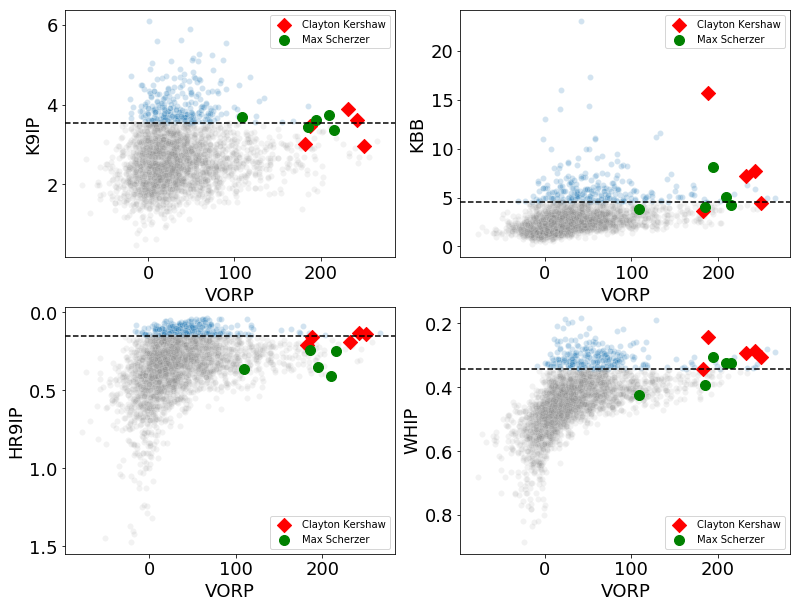

In [24]:
# We produce plots to compare the performance of these two players with the rest, during the five years
fig = plt.figure(figsize=(13., 10.))
metrics=['K9IP','KBB','HR9IP','WHIP']
for i,group in enumerate(metrics):
    if group == 'HR9IP' or group == 'WHIP':
       df6_high=df6[df6[group]<np.percentile(df6[group],10)]
       df6_low=df6[df6[group]>=np.percentile(df6[group],10)]
    else:
       df6_high=df6[df6[group]>np.percentile(df6[group],90)]
       df6_low=df6[df6[group]<=np.percentile(df6[group],90)]
    ax = fig.add_subplot(2,2,i+1)
    g = sns.scatterplot(df6_high['VORP'],df6_high[group],alpha=0.2)
    g = sns.scatterplot(df6_low['VORP'],df6_low[group],alpha=0.1,color='grey')
    g.set_ylabel(group, fontsize=18)
    g.set_xlabel('VORP', fontsize=18)
    ax.tick_params(axis='both', labelsize=18)
    g.scatter(df_clay['VORP'],df_clay[group],s=100,label='Clayton Kershaw',marker='D',color='red')
    g.scatter(df_max['VORP'],df_max[group],s=100,label='Max Scherzer',color='green')
    if group == 'HR9IP' or group == 'WHIP':
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.axhline(np.percentile(df6[group],10),ls='--',color='black')
    else:
        ax.axhline(np.percentile(df6[group],90),ls='--',color='black')
    ax.legend()
# plt.savefig('VORP_max.pdf', bbox_inches='tight',dpi=72)
None